# Results of running the modified samSpeedComp script, on config2

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
import pandas as pd 
import sys
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + mpl.__version__)

Python version 3.7.2 (default, Jan 16 2019, 19:49:22) 
[GCC 8.2.1 20181215 (Red Hat 8.2.1-6)]
Pandas version 0.24.1
Matplotlib version 3.0.2


# Output file overview:

In [2]:
filepath = '../outputs/out_conf2_ssd_hdd_sam_refactored.csv'
df = pd.read_csv(filepath)
df['strategy'] = df['strategy'].map(lambda name : name.split('.')[1].lower())
df['sample'] = df['sample'].map(lambda name : name.split('.')[0])
df.head()

,sample,hardware_type,file_system,strategy,split_time,merge_time,split_nb_seeks,merge_nb_seeks,split_read_time,merge_read_time,split_write_time,merge_write_time,split_seek_time,merge_seek_time
0,bigBrainSample0-1-1,ssd,ext4,clustered,37.941670,43.312993,2824,3388009,23.917343,0.047874,2.222004,24.715344,0,0
1,bigBrainSample0-1-1,ssd,ext4,naive,116.800664,74.994181,3726808,3388009,25.152605,22.892937,89.351954,43.539524,0,0
2,bigBrainSample1-0-1,hdd,ext4,multiple,68.779004,107.780514,0,3388011,16.477029,0.004431,2.263853,50.680392,0,0
3,bigBrainSample1-1-1,hdd,ext4,clustered,107.136569,110.409914,2824,3388009,92.570329,0.048246,2.799134,60.029555,0,0
4,bigBrainSample1-1-1,ssd,ext4,clustered,35.065954,42.897576,2824,3388009,21.058149,0.053984,2.192394,25.586255,0,0


# Comparison of strategies results 

## Notes
Naive strategy:  
-TMPFS: split time > merge time  
-HDD: split time < merge time  

Splitting times:   
-TMPFS: clustered < multiple   
-HDD: clustered ~= multiple    

Merging times:    
-TMPFS: clustered > multiple   
-HDD: clustered < multiple  

Total times:    
-TMPFS: clustered < multiple   
-HDD: clustered < multiple  

strategies comparison for ssd:

            split_time  merge_time  total_time
strategy                                     
clustered   36.112965   43.840279   79.953244
multiple    40.118151   51.627040   91.745191
naive      109.088138   74.556262  183.644400 


strategies comparison for hdd:

            split_time  merge_time  total_time
strategy                                     
clustered   93.908848   80.157903  174.066751
multiple    61.833245   82.597080  144.430326
naive      143.347536  117.407486  260.755022 




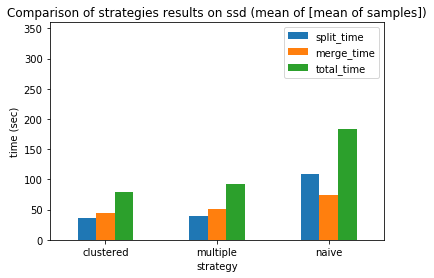

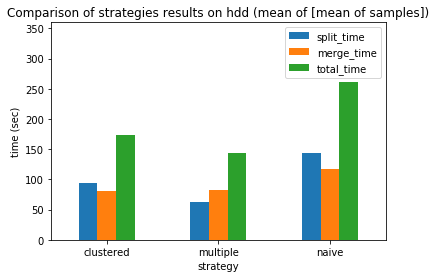

In [5]:
def strategies_comp(tmp, fs_name):
    tmp = tmp.loc[:,:'merge_time']
    tmp['total_time'] = tmp['split_time'] + tmp['merge_time']
    tmp = tmp.groupby('strategy').mean()
    axes=tmp.plot.bar(title='Comparison of strategies results on ' + fs_name + ' (mean of [mean of samples])')
    axes.set_xticklabels(tmp.index, rotation=0)
    axes.set_ylabel("time (sec)")
    axes.set_ylim([0,360])
    print('strategies comparison for ' + fs_name + ':\n\n', tmp, '\n\n')
    
ssd=df[df.hardware_type == 'ssd']
strategies_comp(ssd, 'ssd')
hdd=df[df.hardware_type == 'hdd']
strategies_comp(hdd, 'hdd')

# Reading and writing analysis


Mean of the non IO time for split on ssd:

            split_time  IO_time_split  non_IO_time
strategy                                         
clustered   36.112965      24.343784    11.769181
multiple    40.118151       6.929720    33.188431
naive      109.088138     106.712479     2.375659

Mean of the non IO time for merge on ssd:

            merge_time  IO_time_merge  non_IO_time
strategy                                         
clustered   43.840279      26.189651    17.650628
multiple    51.627040      23.376467    28.250573
naive       74.556262      65.986006     8.570256

Mean of the non IO time for split on hdd:

            split_time  IO_time_split  non_IO_time
strategy                                         
clustered   93.908848      82.184295    11.724553
multiple    61.833245      16.648929    45.184317
naive      143.347536     140.967605     2.379931

Mean of the non IO time for merge on hdd:

            merge_time  IO_time_merge  non_IO_time
strategy            

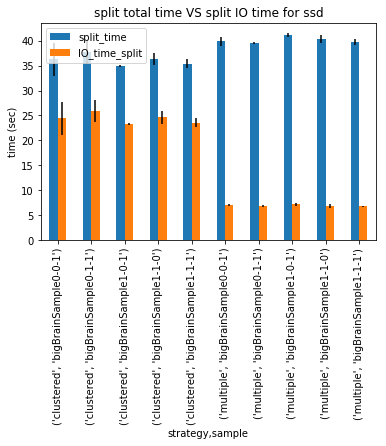

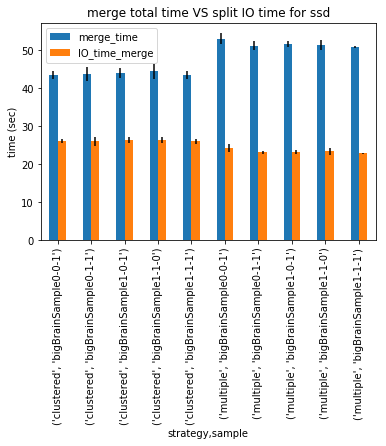

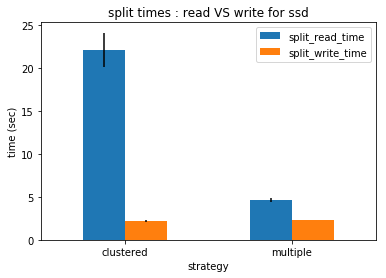

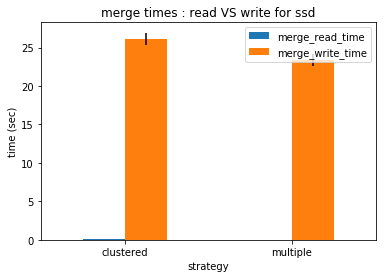

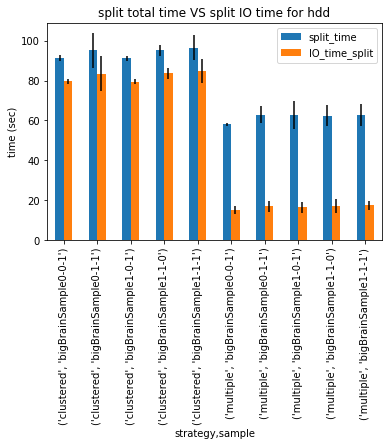

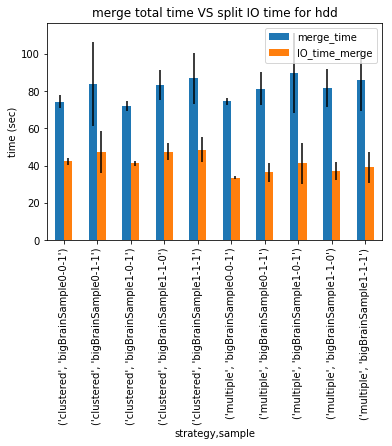

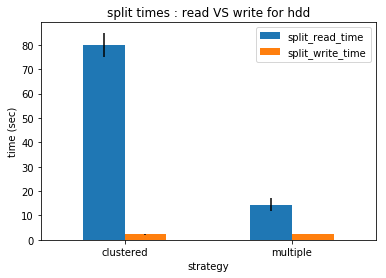

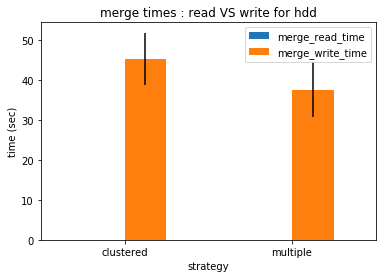

In [11]:
ssd=df[df.hardware_type == 'ssd']
hdd=df[df.hardware_type == 'hdd']

def set_axes(data, axes, rot):
    axes.set_xticklabels(data.index, rotation=rot)
    axes.set_ylabel("time (sec)")

def read_write_sum(data, fstype, time_type):
    rejected = 'split'
    if time_type == 'split':
        rejected='merge'
    data_typed = data[[c for c in data.columns if rejected not in c]]
    group_typed=data_typed.iloc[:,[0,1,2,5]][data_typed['strategy'] != 'naive'].groupby(['strategy','sample'])
    mean_typed = group_typed.mean()
    std_typed = group_typed.std()

    ax1=mean_typed.plot(kind='bar',yerr=std_typed, title=time_type + ' total time VS split IO time for ' + fstype)
    set_axes(mean_typed,ax1, 90)
    
def reads_vs_writes(data, fstype, time_type):
    rejected = 'split'
    if time_type == 'split':
        rejected='merge'
        
    data_wr_typed = data[[c for c in data.columns if rejected not in c]].iloc[:,[0,1,3,4]]
    grp_wr_typed = data_wr_typed[data_wr_typed['strategy'] != 'naive'].groupby(['strategy'])
    grp_wr_typed_mean = grp_wr_typed.mean()
    grp_wr_typed_std = grp_wr_typed.std()

    ax2=grp_wr_typed_mean.plot(kind='bar',yerr=grp_wr_typed_std, title=time_type + ' times : read VS write for ' + fstype)
    set_axes(grp_wr_typed_mean,ax2, 0)

def non_IO(data, fstype, time_type):
    total_time = 2
    IO_time = 8
    
    if time_type == 'merge':
        total_time = 3
        IO_time = 9
        
    grp_non_IO = data.iloc[:,[0,1,total_time, IO_time,10]].groupby(['strategy'])
    grp_non_IO_mean = grp_non_IO.mean()
    grp_non_IO_std = grp_non_IO.std()
    print('\nMean of the non IO time for ' + time_type + ' on ' + fstype + ':\n\n', grp_non_IO_mean)
    
def read_write(data, fstype):
    data=data.iloc[:,[0,3,4,5,8,9,10,11]]
    
    data.loc[:,'IO_time_split'] = data['split_read_time'] + data['split_write_time']
    data.loc[:,'IO_time_merge'] = data['merge_read_time'] + data['merge_write_time']
    
    read_write_sum(data, fstype, 'split')
    read_write_sum(data, fstype, 'merge')
    
    reads_vs_writes(data, fstype, 'split')
    reads_vs_writes(data, fstype, 'merge')
    
    data.loc[:,'non_IO_time'] = data['split_time'] - data['IO_time_split']
    non_IO(data, fstype, 'split')
    data.loc[:,'non_IO_time'] = data['merge_time'] - data['IO_time_merge']
    non_IO(data, fstype, 'merge')
    
    
read_write(ssd, 'ssd')
read_write(hdd, 'hdd')

# Inter and intra sample variability

fs_type: ssd
                               mean split_time
strategy  sample                              
clustered bigBrainSample0-0-1        36.220357
          bigBrainSample0-1-1        37.649402
          bigBrainSample1-0-1        34.956315
          bigBrainSample1-1-0        36.366228
          bigBrainSample1-1-1        35.372523
multiple  bigBrainSample0-0-1        39.867730
          bigBrainSample0-1-1        39.548916
          bigBrainSample1-0-1        41.136706
          bigBrainSample1-1-0        40.326487
          bigBrainSample1-1-1        39.710917
                               std split_time
strategy  sample                             
clustered bigBrainSample0-0-1        3.256027
          bigBrainSample0-1-1        2.324538
          bigBrainSample1-0-1        0.207637
          bigBrainSample1-1-0        1.199445
          bigBrainSample1-1-1        0.913338
multiple  bigBrainSample0-0-1        0.921775
          bigBrainSample0-1-1        0.133181
         

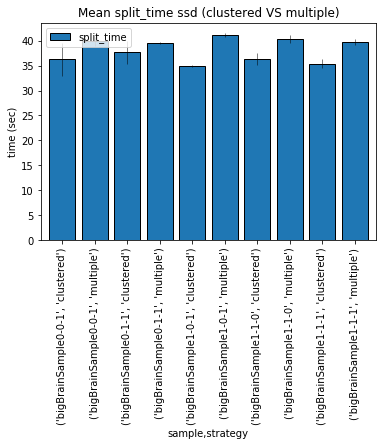

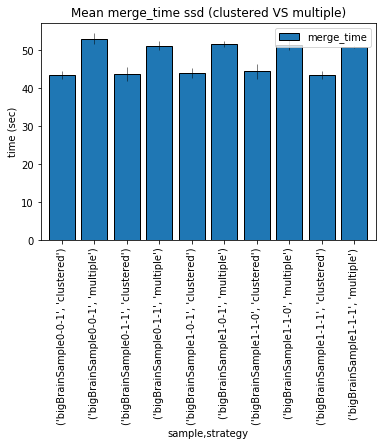

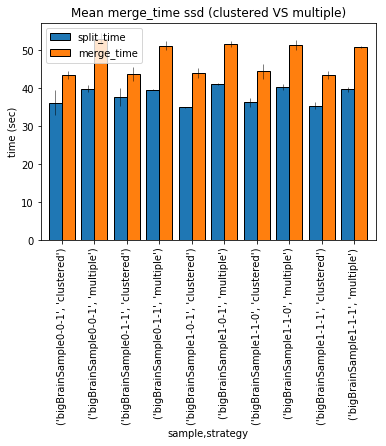

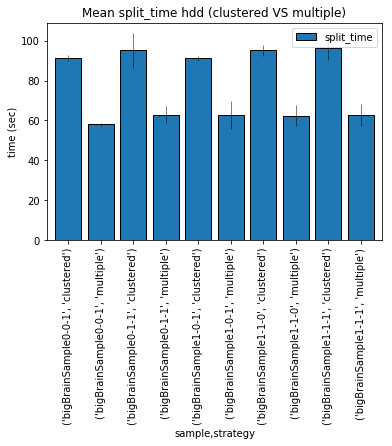

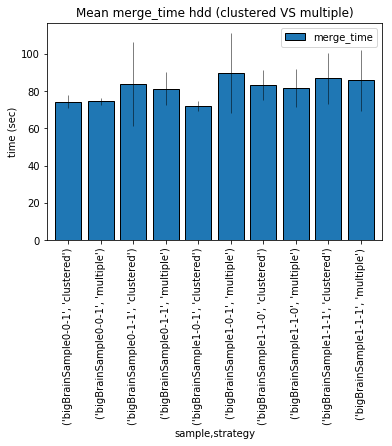

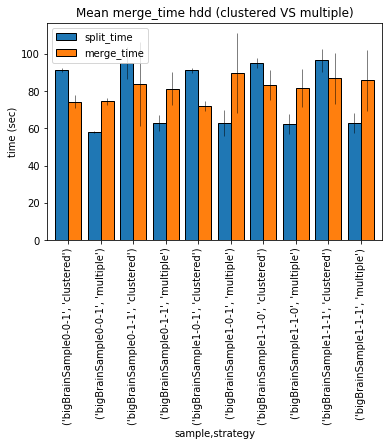

In [12]:
def print_time(data, fs_type, time_type, print_both):
    splits = data[data.strategy != 'naive'].loc[:,:time_type]
    if (time_type=='merge_time') and (not print_both):
        splits=splits.drop('split_time', axis=1)
    
    means=splits.groupby(['sample', 'strategy']).mean()
    std=splits.groupby(['sample', 'strategy']).std()

    ax=means.plot(kind='bar', title='Mean ' + time_type + ' ' + fs_type + ' (clustered VS multiple)',yerr=std,edgecolor='black',error_kw=dict(ecolor='black',elinewidth=0.5),width=0.8)
    ax.set_xticklabels(means.index, rotation=90)
    ax.set_ylabel("time (sec)")
    
    if not print_both:
        print("fs_type:", fs_type)
        splits.rename(columns={time_type:'mean '+ time_type}, inplace=True)
        print(splits.groupby(['strategy', 'sample']).mean())
        splits.rename(columns={'mean '+ time_type:'std '+time_type}, inplace=True)
        print(splits.groupby(['strategy', 'sample']).std())

ssd=df[df.hardware_type == 'ssd']
print_time(ssd, 'ssd', 'split_time', None)
print_time(ssd, 'ssd', 'merge_time', False)
print_time(ssd, 'ssd', 'merge_time', True)

hdd=df[df.hardware_type == 'hdd']
print_time(hdd, 'hdd', 'split_time', None)
print_time(hdd, 'hdd', 'merge_time', False)
print_time(hdd, 'hdd', 'merge_time', True)